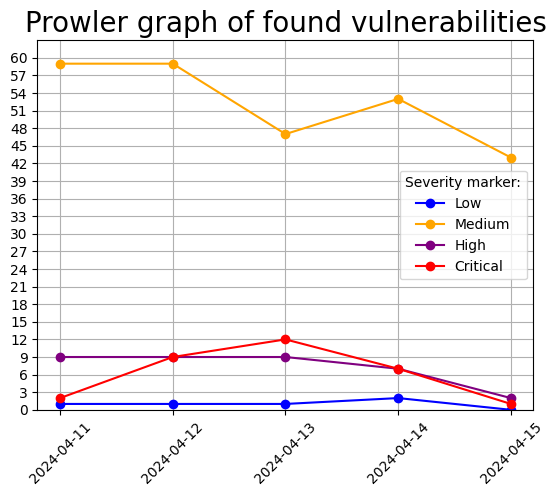

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import time


def get_param_from_json(file_name):

    file_name = os.path.join(folder_path, file_name)

    with open(file_name, "r") as f:
        data = json.load(f)

    dict_counter = {'Low':0, 'Medium':0, 'High':0, 'Critical':0}
    
    date_time = data[0]['finding_info']['created_time']

    
    for resource in data:

        if resource['status_code'] == 'FAIL':
             dict_counter[resource['severity']] += 1

    return dict_counter, date_time


folder_path = '/home/pespav/Projects_GCP/venv/output'

files_list = os.listdir(folder_path)

filtered_files_list = [file for file in files_list if file.startswith('prowler-output-default-') and file.endswith('.json')]

filtered_files_list = sorted(filtered_files_list)

low, medium, high, critical = [],[],[],[]

file_dates = []

for file in filtered_files_list:
    d, date_time = get_param_from_json(file)

    low.append(d["Low"])
    medium.append(d["Medium"])
    high.append(d["High"])
    critical.append(d["Critical"])

    file_dates.append(date_time[:-16])


# Настройка цветов линий и точек
plt.plot(low, color='blue', marker='o', label='Low')
plt.plot(medium, color='orange', marker='o', label='Medium')
plt.plot(high, color='purple', marker='o', label='High')
plt.plot(critical, color='red', marker='o', label='Critical')

# Добавление сетки
plt.grid(True)

plt.title(label="Prowler graph of found vulnerabilities",
          fontsize=20)

# Добавление легенды
plt.legend(title='Severity marker:')

# Установка меток оси x с числовым форматом дат
plt.xticks(range(len(file_dates)), file_dates, rotation=45)

# Установка меток на оси y через каждые 2 значения
plt.yticks(range(0, max(max(low), max(medium), max(high), max(critical)) + 4, 3))

# Установка диапазона значений на оси y
plt.ylim(0, max(max(low), max(medium), max(high), max(critical)) + 4)


plt.show()

In [41]:
file_name = os.path.join(folder_path, filtered_files_list[0])

with open(file_name, "r") as f:
    data_test = json.load(f)

data_test[0]

{'metadata': {'product': {'name': 'Prowler',
   'vendor_name': 'Prowler',
   'version': '4.0.1'},
  'version': '1.1.0'},
 'severity_id': 4,
 'severity': 'High',
 'status': 'New',
 'status_code': 'FAIL',
 'status_detail': 'Bucket nyal2311 is publicly accessible.',
 'status_id': 1,
 'activity_name': 'Create',
 'activity_id': 1,
 'finding_info': {'created_time': '2024-04-11T19:09:51.586510',
  'desc': 'Ensure That Cloud Storage Bucket Is Not Anonymously or Publicly Accessible',
  'product_uid': 'prowler',
  'title': 'Ensure That Cloud Storage Bucket Is Not Anonymously or Publicly Accessible',
  'uid': 'prowler-gcp-cloudstorage_bucket_public_access-study-project-414406-US-EAST1-nyal2311'},
 'resources': [{'region': 'US-EAST1',
   'group': {'name': 'cloudstorage'},
   'labels': [],
   'name': 'nyal2311',
   'type': 'Bucket',
   'uid': 'nyal2311'}],
 'category_name': 'Findings',
 'category_uid': 2,
 'class_name': 'DetectionFinding',
 'class_uid': 2004,
 'cloud': {'account': {'name': 'study-p

In [2]:
result_to_csv = pd.DataFrame(columns=['date_time', 'status', 'severity', 'status_detail', 'info', 'remediation', 'remediation_references', 'old_status_code', 'new_status_code'])

result_to_csv

,date_time,status,severity,status_detail,info,remediation,remediation_references,old_status_code,new_status_code


In [4]:
for idx in range(1, len(filtered_files_list)):
    
    file_name1 = os.path.join(folder_path, filtered_files_list[idx-1])
    file_name2 = os.path.join(folder_path, filtered_files_list[idx])

    with open(file_name1, "r") as f:
        data1 = json.load(f)

    with open(file_name2, "r") as f:
        data2 = json.load(f)


    for resource_next_file in data2:
        for resource_first_file in data1:
            if resource_next_file['finding_info']['uid'] == resource_first_file['finding_info']['uid'] and \
            resource_next_file['status_code'] != resource_first_file['status_code']:
                
                status = 'new' if resource_first_file['status_code'] == 'PASS' else 'fixed'

                data_dict_list = [
                    {
                        'date_time': resource_next_file['finding_info']['created_time'],
                        'status' : status,
                        'severity': resource_next_file['severity'],
                        'status_detail': resource_next_file['status_detail'],
                        'info' : resource_next_file['finding_info']['desc'],
                        'remediation' : resource_next_file['remediation']['desc'],
                        'remediation_references': resource_next_file['remediation']['references'],
                        'old_status_code' : resource_first_file['status_code'],
                        'new_status_code' : resource_next_file['status_code']
                    }
                ]
                
                df = pd.DataFrame(data_dict_list, columns=['date_time', 'status', 'severity', 'status_detail', 'info', 'remediation', 'remediation_references', 'old_status_code', 'new_status_code'])

                result_to_csv = pd.concat([result_to_csv, df], ignore_index=True)

current_time = time.time()

formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', time.localtime(current_time))

result_to_csv.to_csv(f'prowler_report_csv_{formatted_time}.csv')
